In [1]:
!pip install skorch -q

In [2]:
!pip install torch transformers -q

In [3]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-6lvy2mgj
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-6lvy2mgj
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 5.3 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=f3409b8c94cc2dfccabd0969c8b6a843f630e35a66382ba25680f093a162545d
  Stored in directory: /tmp/pip-ephem-wheel-cache-dlkf3w_8/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python
  Attempting uninstall: skorch
    Found existing installation: skorch 0.15.0
    Uninstalling skorch-0.15.0:
      Successfully uninstalled skorch-0.15.0


In [4]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from skorch import NeuralNetClassifier

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
from modAL.disagreement import vote_entropy, KL_max_disagreement
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [8]:
df = pd.read_csv("/kaggle/input/spam-email/spam.csv")

In [9]:
df=df.dropna()                                     
df=df.reset_index(drop=True) 

In [10]:
df['label'] = df['Category'].map({'ham': 0,
                                  'spam': 1})

In [11]:
df.head()

,Category,Message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


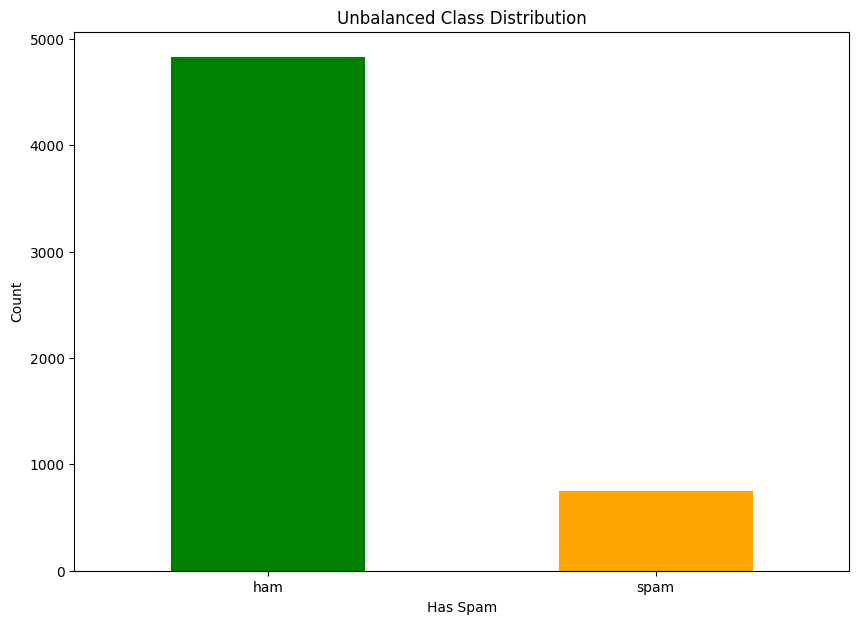

In [12]:
# Counting the occurrences of each category
spam_counts = df['Category'].value_counts()

# Plotting the counts
plt.figure(figsize=(10, 7))  # Set the figure size as needed
spam_counts.plot(kind='bar', color=['green', 'orange'])  # Choose colors as desired
plt.title('Unbalanced Class Distribution')
plt.xlabel('Has Spam')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keeps the labels on the x-axis aligned horizontally
plt.show()

In [13]:
import pandas as pd
from sklearn.utils import resample

# Assuming df is your DataFrame and 'label' is the column with binary classes where 'spam' is 1 and 'ham' is 0

# Separate the classes
df_majority = df[df.label == 0]  # Class 'ham'
df_minority = df[df.label == 1]  # Class 'spam'

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print(df_upsampled.label.value_counts())

label
0    4825
1    4825
Name: count, dtype: int64


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_upsampled["Message"],df_upsampled["label"], test_size=1-0.8, random_state=42)
print(X_train.shape)
print(y_train.shape)

(7720,)
(7720,)


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
sequence_train=tokenizer.texts_to_sequences(X_train)
sequence_test=tokenizer.texts_to_sequences(X_test)

2024-05-02 06:58:59.094053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 06:58:59.094155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 06:58:59.217462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
sequence_train[:10]

[[636, 2849, 17, 3, 3211, 11],
 [353,
  4,
  17,
  163,
  706,
  20,
  583,
  38,
  1060,
  250,
  4,
  222,
  3,
  27,
  1,
  407,
  1269,
  2222,
  197,
  67,
  109,
  2223,
  46,
  2,
  189,
  15,
  2850],
 [4,
  138,
  17,
  109,
  20,
  7,
  3587,
  16,
  32,
  2461,
  4,
  114,
  16,
  257,
  82,
  2,
  721,
  25,
  4,
  4081,
  132,
  2,
  51,
  4,
  126,
  412,
  16,
  32,
  777],
 [73,
  5,
  2032,
  23,
  7,
  156,
  7,
  438,
  22,
  1061,
  143,
  15,
  272,
  157,
  56,
  292,
  193,
  258,
  68,
  112,
  148,
  146,
  1015,
  1348,
  1349,
  568,
  1062,
  103],
 [100,
  606,
  116,
  683,
  380,
  2462,
  1616,
  535,
  100,
  606,
  9,
  1517,
  52,
  31,
  1,
  1016,
  93,
  293,
  1518],
 [569, 45, 87, 46, 2, 3212, 6, 4970, 4082, 4083, 493, 4084, 6, 4085, 1209],
 [47,
  1017,
  23,
  1519,
  3,
  707,
  5,
  22,
  1270,
  96,
  259,
  133,
  1880,
  1,
  648,
  475,
  1881,
  408,
  20,
  25,
  1153,
  1882,
  99,
  27,
  1063,
  1,
  1105,
  1883,
  52,
  31,
  1105,

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(7720, 121)

In [18]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(1930, 121)

In [19]:
X_test = torch.tensor(data_test)
X_train = torch.tensor(data_train)

In [20]:
data_test[:10]

array([[   0,    0,    0, ...,   46,    2,  956],
       [   0,    0,    0, ...,   32,  667, 2188],
       [   0,    0,    0, ...,   82,   58, 2535],
       ...,
       [   0,    0,    0, ...,    4,  473,  956],
       [   0,    0,    0, ...,  185,  361, 2241],
       [   0,    0,    0, ..., 1258,  107,  120]], dtype=int32)

In [21]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_dim, vocab_size, embedding_dim, lstm_units):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.spatial_dropout = nn.Dropout2d(p=0.2)
        self.lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(lstm_units, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = self.spatial_dropout(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Only take the output of the last time step
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Assuming data_train.shape[1] is your input dimension
input_dim = data_train.shape[1]
# Assuming tokenizer.word_index is your vocabulary size
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # You can adjust this according to your needs
lstm_units = 16

# Initialize your model
model = MyModel(input_dim, vocab_size, embedding_dim, lstm_units)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Print your model
print(model.to(device))


MyModel(
  (embedding): Embedding(8188, 100)
  (spatial_dropout): Dropout2d(p=0.2, inplace=False)
  (lstm): LSTM(100, 16, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=16, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [22]:
X_train.shape

torch.Size([7720, 121])

In [23]:
y_train.shape

(7720,)

In [24]:
y_test = torch.tensor(np.array(y_test))

In [25]:
y_train= torch.tensor(np.array(y_train))


In [26]:
n_initial = 512
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [27]:
X_initial.shape

torch.Size([512, 121])

In [28]:
from modAL.models import ActiveLearner
import modAL


In [29]:
from skorch.callbacks import Callback

class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []

    def on_epoch_end(self, net, **kwargs):
        self.train_loss_history.append(net.history[-1, 'train_loss'])

In [30]:
from torch.optim.lr_scheduler import StepLR

# Define the learning rate
learning_rate = 1e-3
loss_recorder = LossRecorder()
# # Initialize the optimizer with the learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the learning rate scheduler
# scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
classifier = NeuralNetClassifier(model,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam,
                                 lr=learning_rate,
                                 train_split=None,
                                 verbose=1,
                                 device=device,
                                 callbacks=[loss_recorder],
                                )

In [31]:
# create the classifier
learner = ActiveLearner(
    estimator=classifier,
    query_strategy= modAL.uncertainty.uncertainty_sampling,
    X_training=X_initial,
    y_training=y_initial,
    epochs=3
)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6917  0.8591
      2        0.6884  0.0188
      3        0.6872  0.0186


In [32]:
classifier.score(X_initial, y_initial)

0.673828125

In [33]:
classifier.score(X_test, y_test)

0.6113989637305699

In [34]:
from sklearn.metrics import f1_score

In [35]:
def DeepAL(learner, strategy):
    # create the classifier
    learner.query_strategy = strategy
    loss_rec = LossRecorder()
    learner.callbacks=[loss_rec]
    
    # Active learning loop
    n_queries = 25
    sampling_history = []
    training_loss_history = []
    
    global X_pool, y_pool, X_test, y_test
    for idx in range(n_queries):
        print('Query no. %d' % (idx + 1))
        query_idx, _ = learner.query(X_pool, n_instances=10)
        learner.teach(X_pool[query_idx], y_pool[query_idx],
                      only_new=False, epochs=3)

        # Record accuracy and loss
        preds = learner.predict(X_test)
        preds2 = np.round(preds)
        model_accuracy = f1_score(preds2,y_test)
        sampling_history.append(model_accuracy)
        training_loss_history.extend(loss_rec.train_loss_history)  # Collect all epoch losses

        print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
        print('Training losses after query {n}: {losses}'.format(n=idx + 1, losses=loss_rec.train_loss_history))

        # Reset the loss history for the next query
        loss_rec.train_loss_history = []

        # Remove queried instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        
    return sampling_history, training_loss_history, learner

In [36]:
import numpy as np

def random_sampling(classifier, X_pool, n_instances=1, **kwargs):
    n_samples = len(X_pool)
    if n_samples == 0:
        return np.array([])
    query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
    return query_idx

In [37]:
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
# from modAL.disagreement import vote_entropy, KL_max_disagreement
# from modAL.multilabel import avg_confidence, avg_score

strategies = [random_sampling, uncertainty_sampling, margin_sampling, entropy_sampling]

In [38]:
import copy
import pickle

In [39]:
exps = {}
for strat in strategies:
    learner_copy = copy.deepcopy(learner)
    exps[strat.__name__] = DeepAL(learner_copy, strat)

    with open(f'{strat.__name__}_model.pkl', 'wb') as f:
        pickle.dump(exps[strat.__name__][-1].estimator.module, f)

Query no. 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6831  0.0285
      2        0.6794  0.0217
      3        0.6758  0.0211
Accuracy after query 1: 0.6930
Training losses after query 1: []
Query no. 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6717  0.0242
      2        0.6673  0.0213
      3        0.6631  0.0208
Accuracy after query 2: 0.7414
Training losses after query 2: []
Query no. 3
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6591  0.0219
      2        0.6522  0.0211
      3        0.6484  0.0213
Accuracy after query 3: 0.7780
Training losses after query 3: []
Query no. 4
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6444  0.0218
      2        0.6332  0.0215
      3        0.6281  0.0213
Accuracy after query 4: 0.8086
Training losses af

In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl

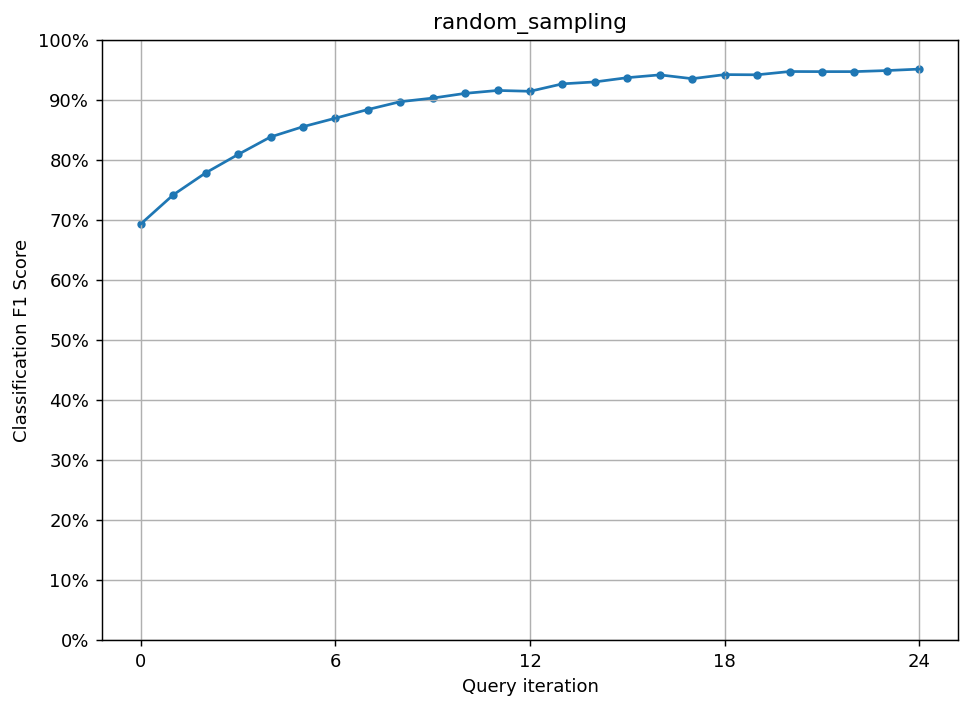

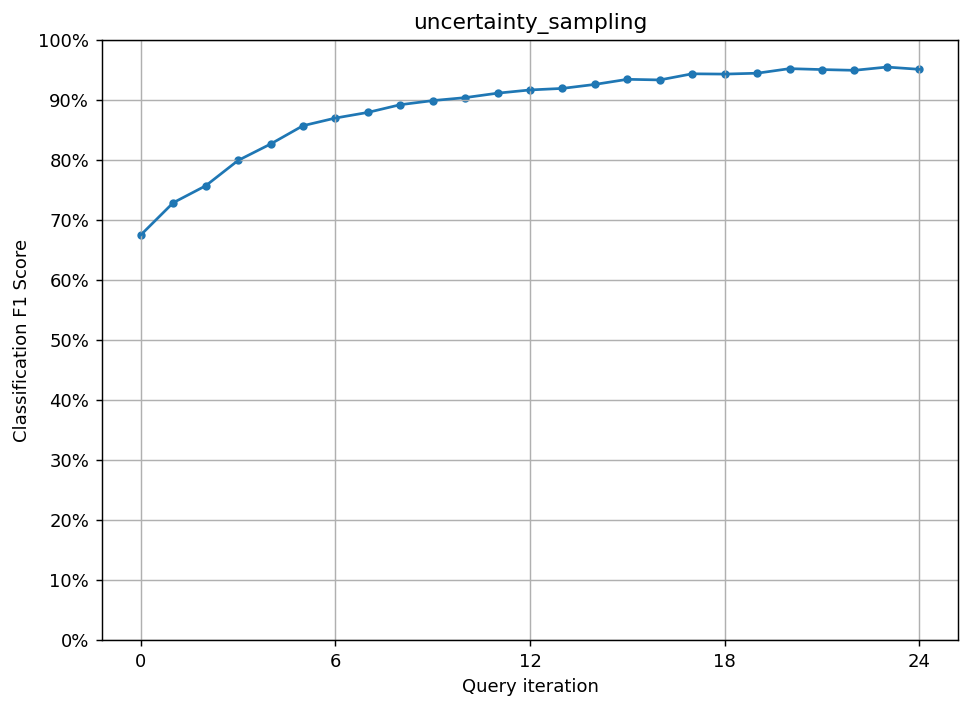

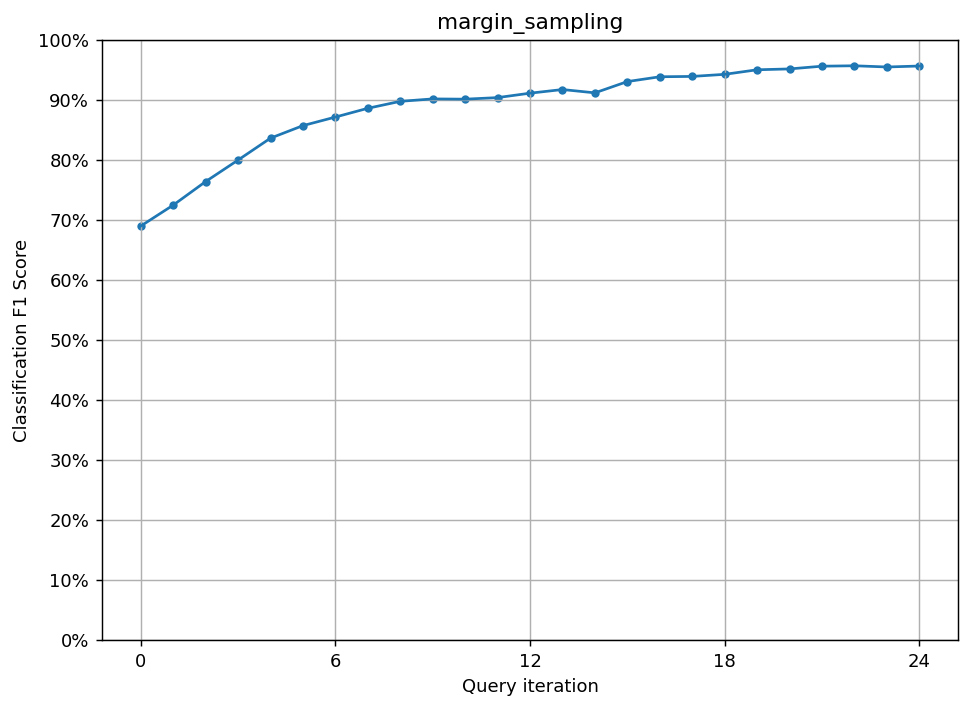

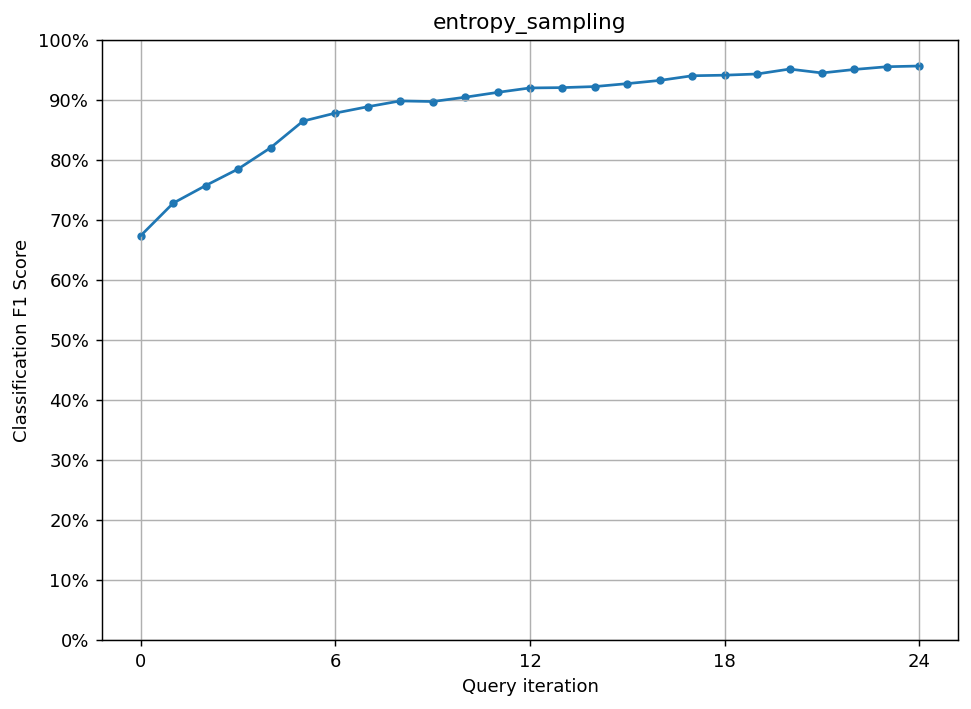

In [41]:
for exp in exps.values():
    # Plot our performance over time.
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.plot(exp[0])
    ax.scatter(range(len(exp[0])), exp[0], s=13)

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)

    ax.set_title(f'{exp[-1].query_strategy.__name__}')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification F1 Score')
plt.show()

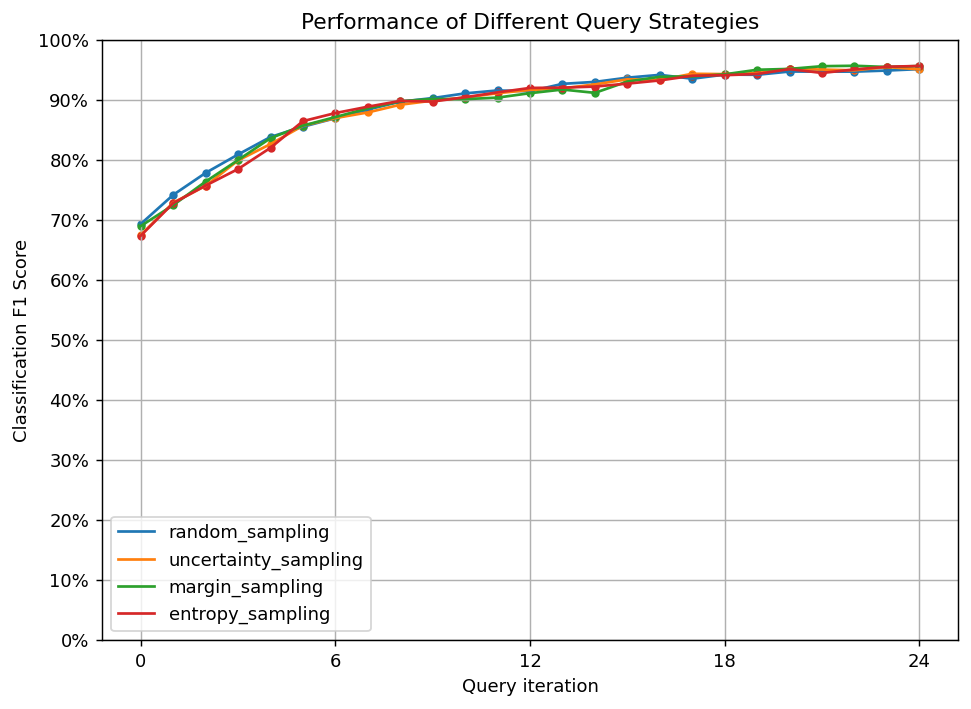

In [42]:
# Create a single figure and axes object
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

# Iterate through each experiment and plot on the same axes
for exp in exps.values():
    ax.plot(exp[0], label=exp[-1].query_strategy.__name__)  # Add label for legend
    ax.scatter(range(len(exp[0])), exp[0], s=13)

# Set up axes formatting (same as before)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True)

# Set up labels and title
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1 Score')
ax.set_title('Performance of Different Query Strategies')  # More general title

# Add a legend to distinguish between different lines
ax.legend()

# Show the plot
plt.show()